In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.image as mpimg
import splitfolders
import cv2
import glob

In [2]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"

response = requests.get(url)
code = response.text

exec(code)

In [3]:
dataset=pd.read_csv("/training_proj/labels.csv")
dataset.head()

train_val_dir='/training_proj/traffic_Data/DATA/'
test_dir='/training_proj/traffic_Data/TEST/'

### Making dictionary


In [4]:
dictionary={}
count=0

for name in dataset['Name']:
    dictionary.update({count:name})
    count+=1
    
    
dictionary    

{0: 'Speed limit (5km/h)',
 1: 'Speed limit (15km/h)',
 2: 'Speed limit (30km/h)',
 3: 'Speed limit (40km/h)',
 4: 'Speed limit (50km/h)',
 5: 'Speed limit (60km/h)',
 6: 'Speed limit (70km/h)',
 7: 'speed limit (80km/h)',
 8: 'Dont Go straight or left',
 9: 'Dont Go straight or Right',
 10: 'Dont Go straight',
 11: 'Dont Go Left',
 12: 'Dont Go Left or Right',
 13: 'Dont Go Right',
 14: 'Dont overtake from Left',
 15: 'No Uturn',
 16: 'No Car',
 17: 'No horn',
 18: 'Speed limit (40km/h)',
 19: 'Speed limit (50km/h)',
 20: 'Go straight or right',
 21: 'Go straight',
 22: 'Go Left',
 23: 'Go Left or right',
 24: 'Go Right',
 25: 'keep Left',
 26: 'keep Right',
 27: 'Roundabout mandatory',
 28: 'watch out for cars',
 29: 'Horn',
 30: 'Bicycles crossing',
 31: 'Uturn',
 32: 'Road Divider',
 33: 'Traffic signals',
 34: 'Danger Ahead',
 35: 'Zebra Crossing',
 36: 'Bicycles crossing',
 37: 'Children crossing',
 38: 'Dangerous curve to the left',
 39: 'Dangerous curve to the right',
 40: 'Unk

## Images preprocessing

In [5]:
# for preprocessing images to predict 

def preprocess_for_pred(image):
    img=cv2.imread(image)
    img=cv2.resize(img,(64,64))
    img=np.asarray(img).astype('float64').reshape(-1,64,64,3)
    return img

In [6]:
# Storing training images paths and labels

train_val_img_path=[]
y=[]
for folder in os.listdir(train_val_dir):
    class_path=os.path.join(train_val_dir,folder)
    for image in os.listdir(class_path):
        train_val_img_path.append(os.path.join(class_path,image))
        y.append(float(folder))

In [7]:
# Storing prediction images and preprocess them for preddictions

test_images_paths=[]
pred_images=[]
for img in os.listdir(test_dir):
    img_path=os.path.join(test_dir,img)
    test_images_paths.append(img_path)
    prep_img=preprocess_for_pred(img_path)
    pred_images.append(prep_img)
    
    

In [8]:
# Reading training images and resizing them 

X=[]
for image in train_val_img_path:
    img=cv2.imread(image)
    img=cv2.resize(img, (64, 64))
    X.append(img)

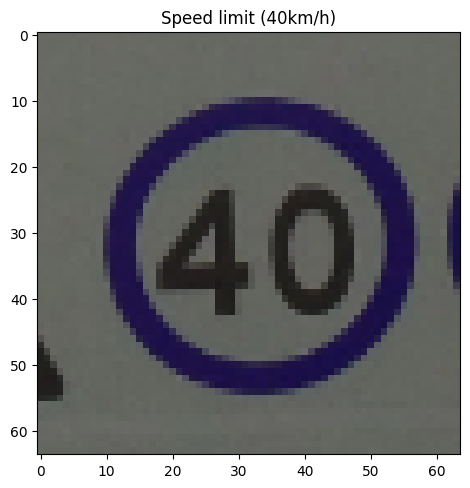

In [9]:
# Visualizing

from PIL import Image
plt.figure(figsize = (12,10))
plt.subplot(1,2,1)

plt.title(dictionary.get(int(y[2000])))
plt.imshow(X[2000])

In [10]:
# Spliting to train and validation(test)

from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [11]:
# Convert to array

X_train=np.asarray(X_train).astype('float64').reshape(-1,64,64,3)

y_train = np.array(y_train)

#Normalization 
X_train=X_train/255


In [12]:
# Convert to array

X_test=np.asarray(X_test).astype('float64').reshape(-1,64,64,3)

y_test = np.array(y_test)

#Normalization 
X_test=X_test/255

In [13]:
# Augmentation for training images

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=15,shear_range=15,width_shift_range=0.05,
          height_shift_range=0.05,zoom_range=0.1)
test_datagen = ImageDataGenerator()
  
  
train_generator = train_datagen.flow(
                  x=X_train,
                  y=y_train,  
                  batch_size = 20,
                  )
  
  
test_generator = test_datagen.flow(
                    x=X_test,
                    y=y_test,
                    batch_size = 20,
                    )

In [14]:
test_generator.x.shape

(834, 64, 64, 3)

## The Model

In [15]:
import keras
def myModel():
    input = keras.Input(shape= (64,64,3))
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(input)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu',)(x)
    x = keras.layers.Dropout(0.4)(x)
    out1 = keras.layers.Dense(58, activation='softmax',name='Char1')(x)
    model = keras.models.Model(inputs=input,outputs=[out1,
                                                     
                                                     ])
    return model



model =myModel()



model.compile(
    optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


model_history=model.fit(
    train_generator,
    validation_data = test_generator,
    epochs=30,
    validation_steps = 20
    )

Epoch 1/30
167/167 [==============================] - 12s 37ms/step - loss: 3.0906 - accuracy: 0.2029 - val_loss: 2.3244 - val_accuracy: 0.3050
Epoch 2/30
167/167 [==============================] - 5s 32ms/step - loss: 2.0189 - accuracy: 0.4044 - val_loss: 1.4400 - val_accuracy: 0.5550
Epoch 3/30
167/167 [==============================] - 6s 33ms/step - loss: 1.3076 - accuracy: 0.5950 - val_loss: 0.8301 - val_accuracy: 0.7725
Epoch 4/30
167/167 [==============================] - 5s 32ms/step - loss: 0.8923 - accuracy: 0.7137 - val_loss: 0.5499 - val_accuracy: 0.8425
Epoch 5/30
167/167 [==============================] - 5s 32ms/step - loss: 0.6351 - accuracy: 0.7965 - val_loss: 0.4876 - val_accuracy: 0.8500
Epoch 6/30
167/167 [==============================] - 6s 33ms/step - loss: 0.5323 - accuracy: 0.8294 - val_loss: 0.5108 - val_accuracy: 0.8400
Epoch 7/30
167/167 [==============================] - 6s 34ms/step - loss: 0.4241 - accuracy: 0.8639 - val_loss: 0.2709 - val_accuracy: 0.917

## Loss-Accuracy Curves

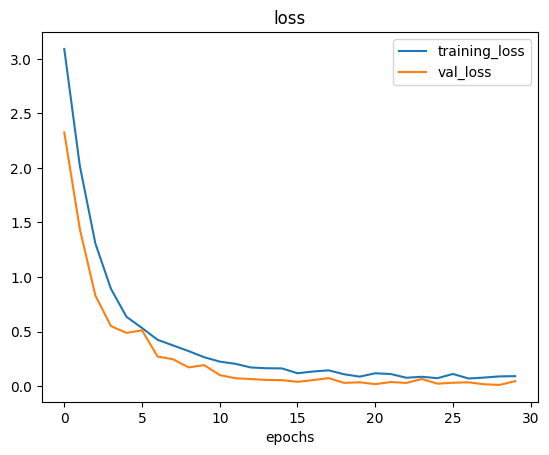

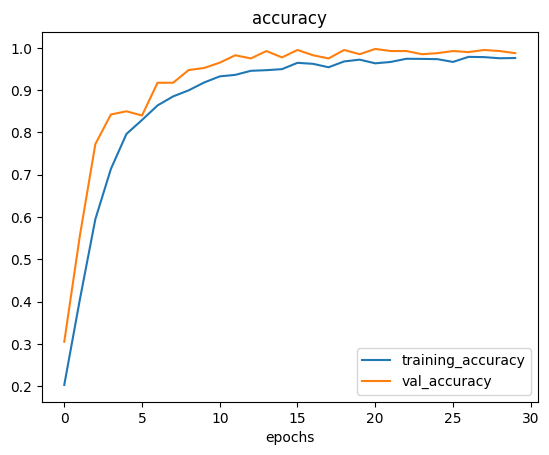

In [16]:
plot_loss_curves(model_history)

## Results (Predictions)

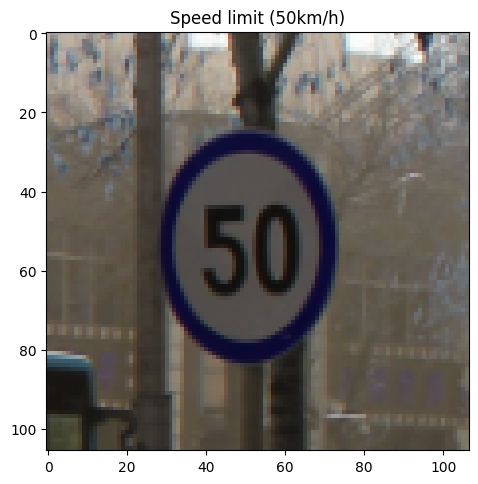

In [17]:

# # the prediction 
y_pred=model.predict(pred_images[200]).argmax()

pred=dictionary.get(y_pred)
pred

# Checking for the truth of prediction

from PIL import Image
plt.figure(figsize = (12,10))
plt.subplot(1,2,1)

plt.title(pred)
plt.imshow(cv2.imread(test_images_paths[200]))